In [112]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, Add, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Utils

In [113]:
def block(x, filters, kernel_size=3, stride=1):

    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)


    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)

    x = Add()([x, shortcut])
    return x

In [114]:
def residual_block(x, filters, kernel_size=3, stride=1):

    shortcut = x

    x = block(x, filters, kernel_size=kernel_size, stride=stride)
    x = block(x, filters, kernel_size=kernel_size, stride=stride)
    x = block(x, filters, kernel_size=kernel_size, stride=stride)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)

    x = Add()([x, shortcut])
    
    return x

In [115]:
def build_encoder(input_shape):
    stride = 1
    C = 2
    filters = 128
    input_tensor = Input(shape=input_shape)
    
    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x_0 = x

    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)

    x = block(x, filters, kernel_size=3, stride = 1)

    w = Add()([x, x_0])

    w = Conv2D(C, kernel_size=5, strides=2, padding='same')(w)
    w = BatchNormalization()(w)
    
    encoder = Model(input_tensor, w, name="encoder")
    return encoder


def build_generator(input_shape):
    stride = 1
    filters = 128
    latent_inputs = Input(shape=input_shape)
    
    w_hat = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(latent_inputs)
    w_hat = BatchNormalization()(w_hat)
    w_hat = ReLU()(w_hat)
    
    w_0 = w_hat

    w_hat = residual_block(w_hat, filters, stride)
    w_hat = residual_block(w_hat, filters, stride)
    w_hat = residual_block(w_hat, filters, stride)
    w_hat = residual_block(w_hat, filters, stride)
    w_hat = residual_block(w_hat, filters, stride)

    w_hat = block(w_hat, filters, kernel_size=3, stride=1)

    x_hat = Add()([w_hat, w_0])

    x_hat = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x_hat)
    x_hat = BatchNormalization()(x_hat)
    x_hat = ReLU()(x_hat)
    x_hat = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same')(x_hat)
    x_hat = BatchNormalization()(x_hat)

    generator = Model(latent_inputs, x_hat, name="generator")
    return generator

def build_discriminator(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)  
    
    discriminator = Model(inputs, out, name="discriminator")
    return discriminator

## Preprocessing

In [116]:
img = Image.open('gato.jpeg')

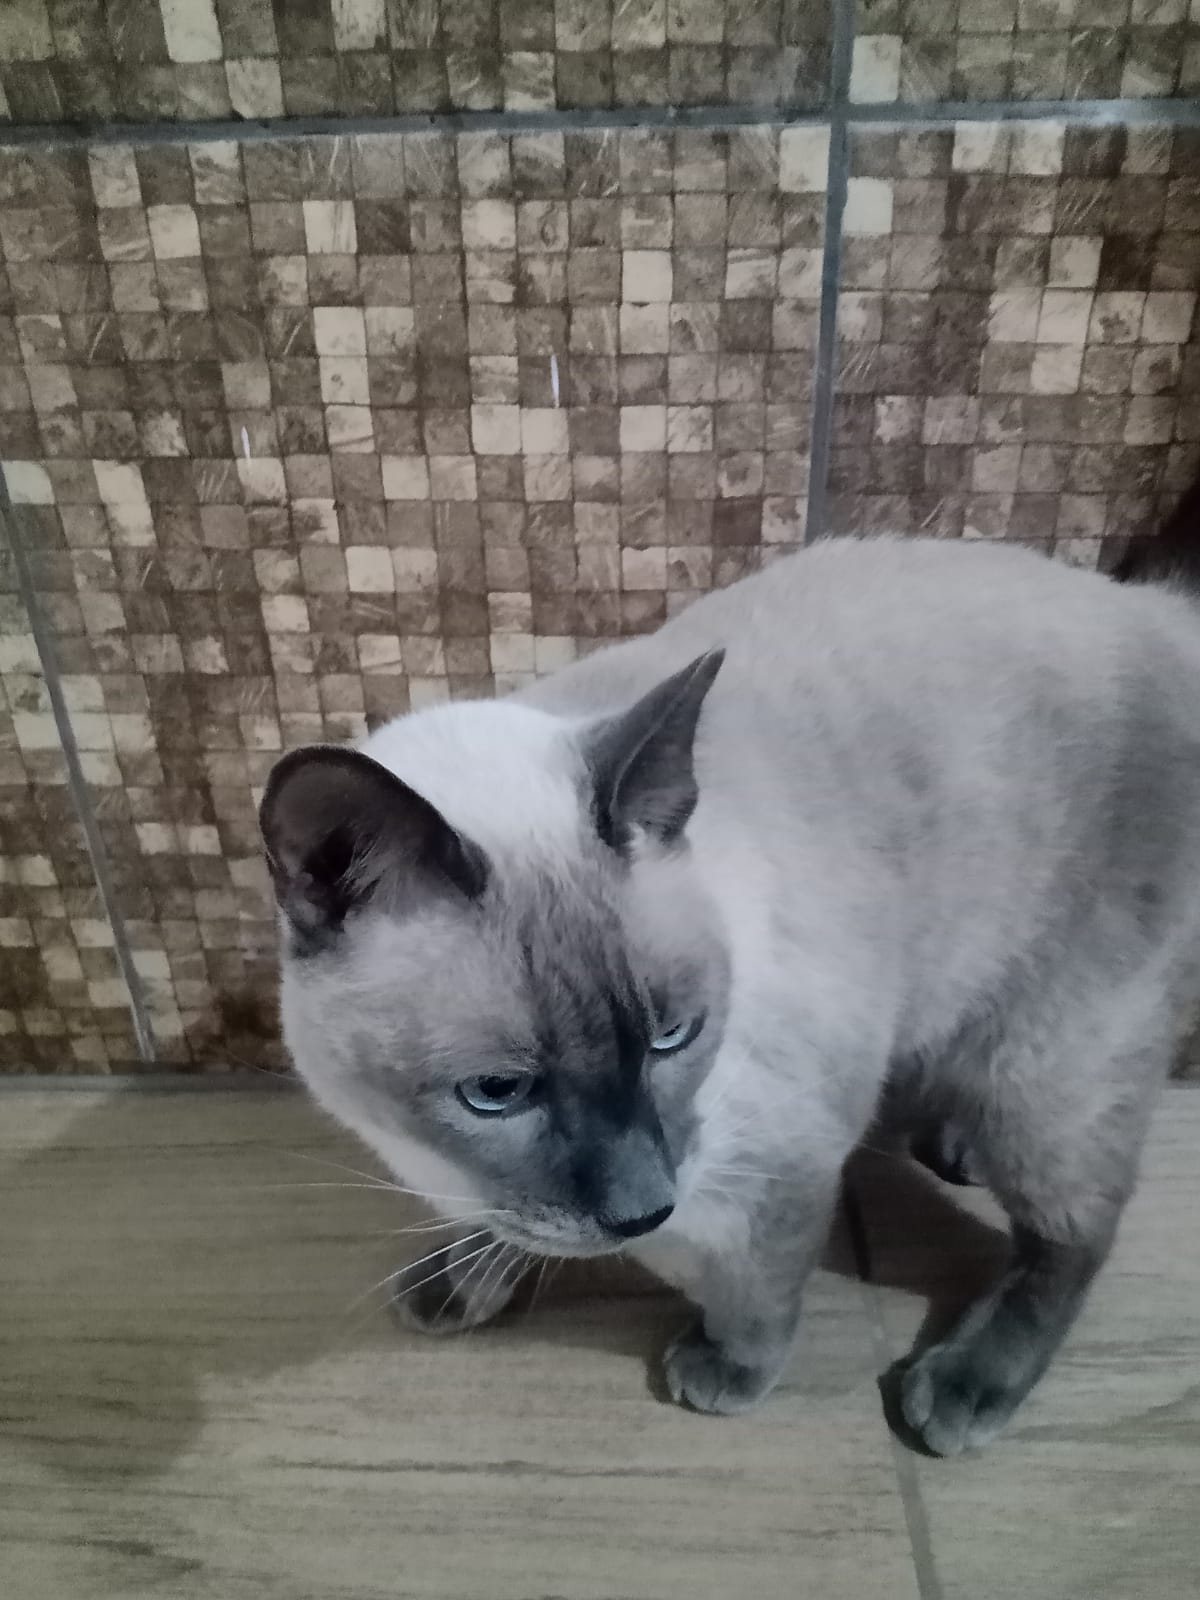

In [117]:
img

In [118]:
img.size

(1200, 1600)

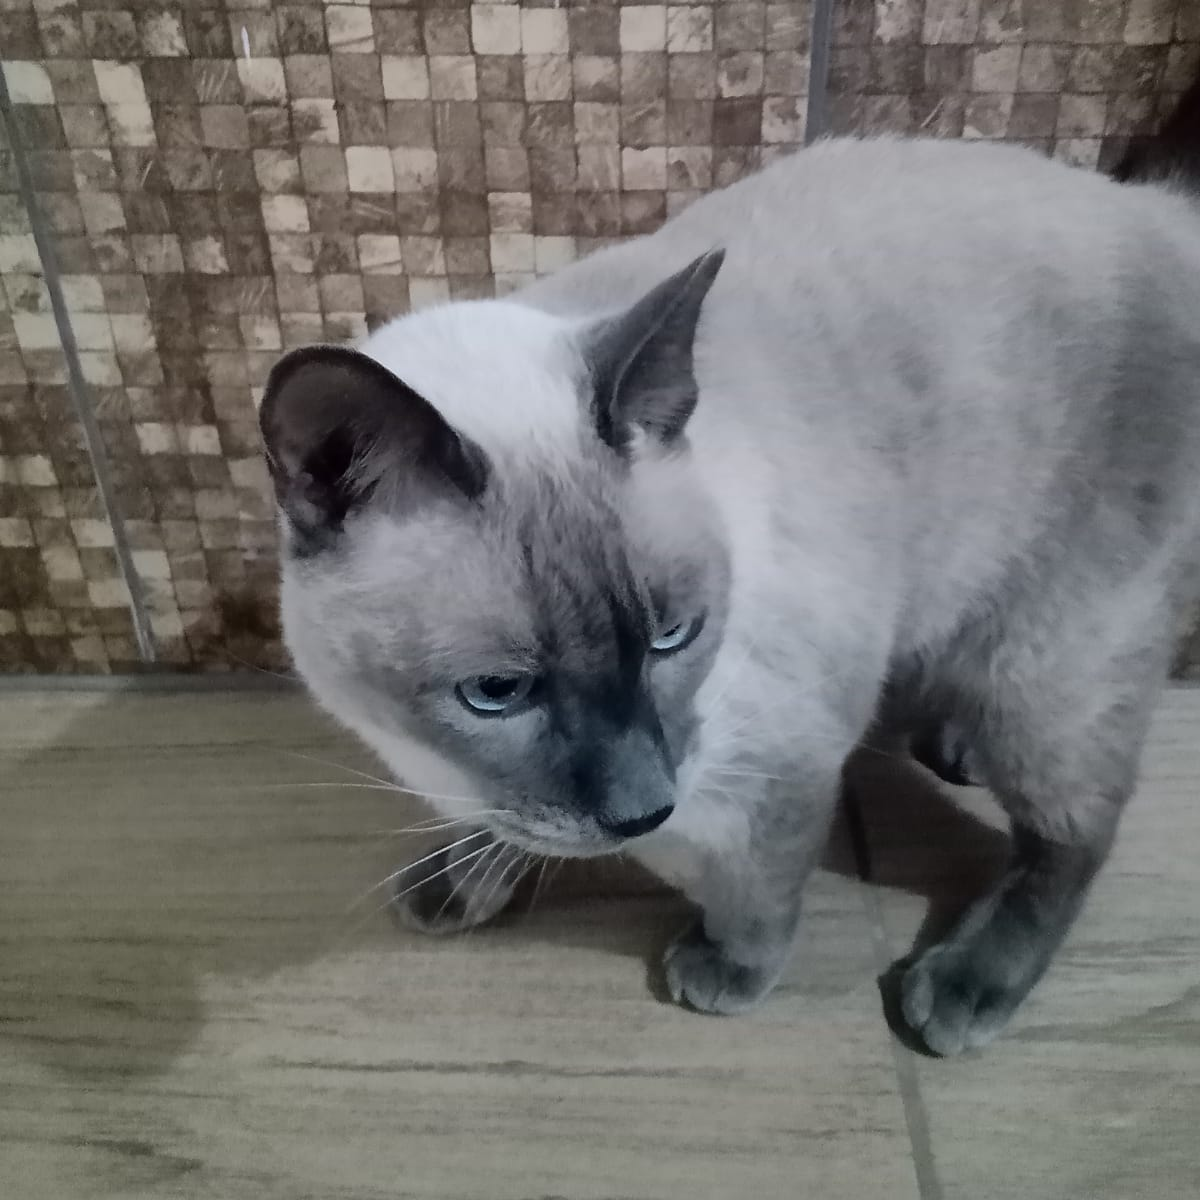

In [119]:
img = img.crop((0, 400, 1200, 1600))
img

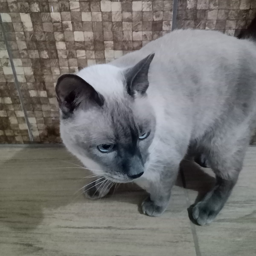

In [120]:
x = img.resize((256, 256))
x

In [121]:
x = np.array(x)
x.shape, x.dtype

((256, 256, 3), dtype('uint8'))

In [122]:
m = x.mean(axis=(0,1))
v = x.var(axis=(0,1))
(x - m).mean(axis=(0,1))

array([0., 0., 0.])

In [123]:
def normalize_input(x):
    _mean = np.array([115., 114., 112.])
    _var = np.array([1450., 1510., 1700.])
    return (x - _mean) / np.sqrt(_var + 1e-10)

In [149]:
def denormalize_output(x_hat):
    _mean = np.array([115., 114., 112.])
    _var = np.array([1450., 1510., 1700.])
    x = x_hat * np.sqrt(_var + 1e-10) + _mean
    x = np.clip(x, a_min=0, a_max=255)
    return x

In [150]:
x0 = normalize_input(x)

## Encoder

In [34]:
encoder = build_encoder((256,256,3))

2024-10-01 10:30:49.114739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-01 10:30:49.115172: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [35]:
# so pra poder o batchnormalization funfar
encoder.compile(optimizer=Adam(learning_rate=0.002), loss='mean_squared_error')
encoder.fit(np.array([x0]), np.ones((1, 32, 32, 2)), epochs=1, batch_size=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 2.0000


In [36]:
w = encoder(np.array([x0]))
w = w.numpy()

In [37]:
np.mean(w[0, :, :, :], axis=(0, 1)), np.var(w[0, :, :, :], axis=(0, 1))

(array([-0.85851985, -0.4602413 ], dtype=float32),
 array([1.1717923, 1.1302054], dtype=float32))

In [38]:
w[0, :, :, 0].min()

-6.5619006

In [39]:
w.shape

(1, 32, 32, 2)

## Quantizer

In [103]:
def quantizer(L, c_min, c_max):
    """
    z: ndarray(B, H, W, C)
    L: int
    """
    def q(z):
        # convert z -> (B, C, H, W)
        z_t = tf.transpose(z, (0, 3, 1, 2))
        z_t_shape = tf.shape(z_t)
        B, C = z_t_shape[:2]
        z_vec = tf.reshape(z_t, [B, C, -1, 1])
        # definir array centers
        centers = np.linspace(float(c_min), float(c_max), L)
        # definir tensor dist
        dist = tf.square(tf.abs(z_vec - centers))
        # calcular tensor z_hat
        symbols = tf.reshape(tf.argmin(dist, axis=-1), z_t_shape)
        symbols = tf.transpose(symbols, (0, 2, 3, 1))
        z_hat = tf.convert_to_tensor(centers[symbols])
        return z_hat, symbols
    return q

In [104]:
q = quantizer(5, -2, 2)
w_hat, symbols = q(w)

In [105]:
z_t = tf.transpose(w, (0, 3, 1, 2))
z_t_shape = tf.shape(z_t)
B, C = z_t_shape[:2]
z_vec = tf.reshape(z_t, [B, C, -1, 1])
centers = np.linspace(float(-2), float(2), 5)
dist = tf.square(tf.abs(z_vec - centers))
symbols = tf.reshape(tf.argmin(dist, axis=-1), z_t_shape)
symbols = tf.transpose(symbols, (0, 2, 3, 1))
tf.convert_to_tensor(centers[symbols])

<tf.Tensor: shape=(1, 32, 32, 2), dtype=float64, numpy=
array([[[[ 0.,  0.],
         [-2., -1.],
         [-1., -1.],
         ...,
         [-2., -1.],
         [-2., -2.],
         [-1.,  0.]],

        [[ 0.,  0.],
         [-2., -1.],
         [ 0.,  0.],
         ...,
         [-2., -1.],
         [-2., -1.],
         [-1., -2.]],

        [[ 0.,  0.],
         [-1., -1.],
         [-2.,  1.],
         ...,
         [-1.,  1.],
         [-2., -2.],
         [-1., -1.]],

        ...,

        [[-1.,  1.],
         [-1.,  1.],
         [-1.,  0.],
         ...,
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         ...,
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         ...,
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]]])>

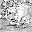

In [106]:
w_vis = np.uint8(63*(w_hat + 2))
Image.fromarray(w_vis[0])

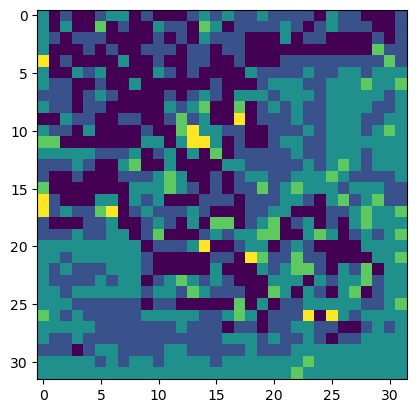

In [107]:
plt.imshow(w_vis[0,:,:,0])

## Generator

In [46]:
generator = build_generator((32,32,2))

In [47]:
generator.compile(optimizer=Adam(), loss='mean_squared_error')
generator.fit(w_hat, np.ones((1, 256, 256, 3)), epochs=1, batch_size=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 1.9951


In [48]:
generator.input_shape

(None, 32, 32, 2)

In [49]:
w_hat.shape

(1, 32, 32, 2)

In [50]:
x_hat = generator(w_hat).numpy()

(array([1.40000e+01, 1.73000e+02, 1.24700e+03, 7.77300e+03, 3.93670e+04,
        1.02978e+05, 3.56690e+04, 7.71600e+03, 1.52800e+03, 1.43000e+02]),
 array([-2.969891  , -2.4234278 , -1.8769643 , -1.3305011 , -0.7840377 ,
        -0.23757434,  0.308889  ,  0.85535234,  1.4018157 ,  1.948279  ,
         2.4947424 ], dtype=float32),
 <BarContainer object of 10 artists>)

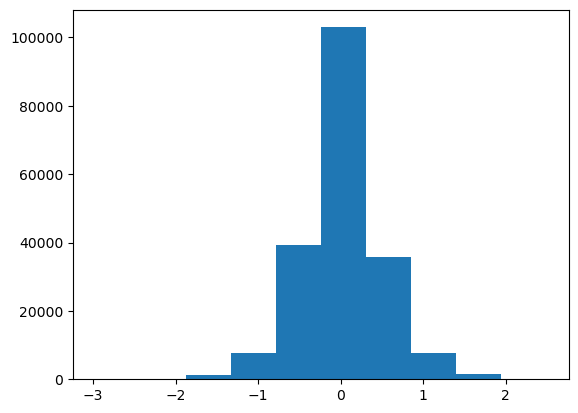

In [51]:
plt.hist(x_hat[0].ravel())

In [52]:
x_hat = np.uint8(denormalize_output(x_hat))

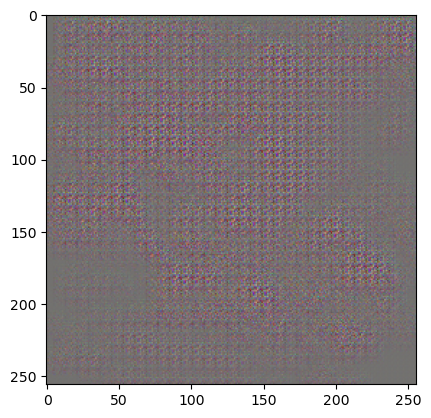

In [53]:
plt.imshow(x_hat[0])

## Discriminator

In [54]:
disc = build_discriminator((256,256,3))

In [55]:
disc.compile(optimizer=Adam(), loss='mean_squared_error')
disc.fit(np.array([x]), np.array([1]), epochs=1, batch_size=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step - loss: 0.9190


In [56]:
disc(np.array([x])).numpy()

array([[1.3766665e-28]], dtype=float32)

## Dataset

In [57]:
import scipy.io

In [58]:
mat = scipy.io.loadmat('../cocostuff-10k-v1.1(1)/annotations/COCO_train2014_000000000077.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Apr  6 19:02:23 2017',
 '__version__': '1.0',
 '__globals__': [],
 'S': array([[157, 157, 157, ..., 169, 169, 169],
        [157, 157, 157, ..., 169, 169, 169],
        [157, 157, 157, ..., 169, 169, 169],
        ...,
        [116, 116, 116, ..., 116, 116, 116],
        [116, 116, 116, ..., 116, 116, 116],
        [116, 116, 116, ..., 116, 116, 116]], dtype=uint8),
 'captions': array([[array(['A young man riding a skateboard into the air.'], dtype='<U45')],
        [array(['a group of teenagers jumping a ramp on their skateboards'],
               dtype='<U56')                                                ],
        [array(['A time lapse image of a guy on a skate board.'], dtype='<U45')],
        [array(['Group of boys performing skateboard trick on ramp with graffiti on it'],
               dtype='<U69')                                                             ],
        [array(['some male skateboarders are

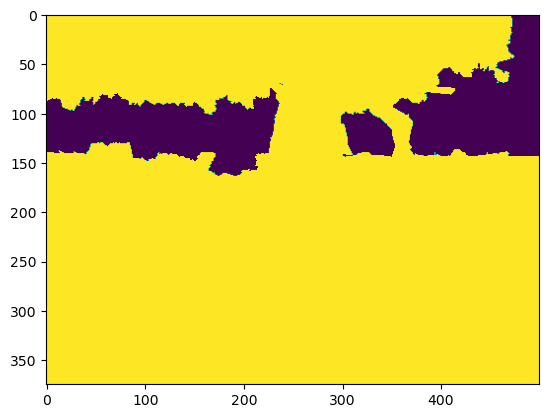

In [59]:
x = mat['S'].copy()
x[x != 169] = 255
plt.imshow(x)

In [60]:
np.unique(mat['S'])

array([  0,   1,  41,  96, 106, 113, 116, 157, 169], dtype=uint8)

## Modelo 

In [151]:
class GenerativeCompressionGAN(Model):
    def __init__(self, encoder, generator, discriminator, num_centroids=5, lambda_recon=10, c_min = -2, c_max = 2):
        super(GenerativeCompressionGAN, self).__init__()
        self.encoder = encoder
        self.generator = generator
        self.discriminator = discriminator
        self.quantizer = quantizer(L=num_centroids, c_min = c_min, c_max = c_max)
        self.lambda_recon = lambda_recon  # Peso para a perda de distorção
        self.num_centroids = num_centroids  # Número de níveis de quantização

    def compile(self, d_optimizer, g_optimizer, gan_loss_fn, distortion_loss_fn):
        super(GenerativeCompressionGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.gan_loss_fn = gan_loss_fn  # Perda adversarial
        self.distortion_loss_fn = distortion_loss_fn  # Perda de distorção 

    def __call__(self, data):
        real_images = normalize_input(data)
        # 1. Encode the image
        encoded_images = self.encoder(real_images)
        # 2. Quantize the latent space
        quantized_latent, _ = self.quantizer(encoded_images) 
        # 3. Generate (Decode) image
        generated_images = self.generator(quantized_latent)
        return denormalize_output(generated_images), quantized_latent

    def train_step(self, data):
        real_images = normalize_input(data)
        
        # 1. Encode the image
        encoded_images = self.encoder(real_images)
        # 2. Quantize the latent space
        quantized_latent, _ = self.quantizer(encoded_images) 
        # 3. Generate (Decode) image
        generated_images = self.generator(quantized_latent)
        
        # 4. Train the discriminator
        with tf.GradientTape() as tape:
            real_output = self.discriminator(real_images)
            fake_output = self.discriminator(generated_images)
            
            # Perda adversarial do discriminador 
            d_loss_real = self.gan_loss_fn(tf.ones_like(real_output), real_output)
            d_loss_fake = self.gan_loss_fn(tf.zeros_like(fake_output), fake_output)
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        # 5. Train the generator (GAN loss, distortion loss, entropy loss)
        with tf.GradientTape() as tape:
            generated_images = self.generator(quantized_latent)
            fake_output = self.discriminator(generated_images)
            
            # Perda adversarial para o gerador (Least-Squares GAN)
            g_gan_loss = self.gan_loss_fn(tf.ones_like(fake_output), fake_output)
            
            # Perda de distorção 
            g_distortion_loss = self.distortion_loss_fn(real_images, generated_images)
            
            
            # Perda total ponderada
            g_loss = g_gan_loss + self.lambda_recon * g_distortion_loss 
        
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        return {"d_loss": d_loss, "g_loss": g_loss}

In [152]:
def least_squares_gan_loss(y_true, y_pred):
    return tf.reduce_mean((y_true - y_pred) ** 2)

In [153]:
# Build models
encoder = build_encoder((256,256,3))
generator = build_generator((32,32,2))
discriminator = build_discriminator((256,256,3))

# Instantiate and compile the GAN
gan = GenerativeCompressionGAN(encoder, generator, discriminator, num_centroids=5, lambda_recon=10)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    gan_loss_fn=least_squares_gan_loss,  
    distortion_loss_fn=tf.keras.losses.MeanAbsoluteError()  
)

In [154]:
gan.train_step(tf.convert_to_tensor(np.array([x])))

{'d_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.31766996>,
 'g_loss': <tf.Tensor: shape=(), dtype=float32, numpy=43.959106>}

In [156]:
xhat, what = gan(x[np.newaxis])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


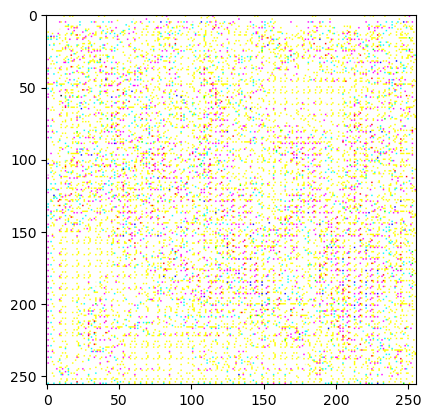

In [158]:
plt.imshow(xhat[0])

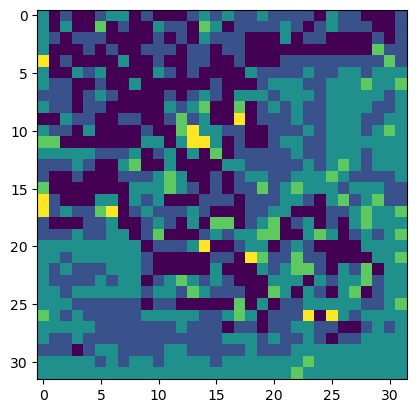

In [160]:
plt.imshow(w_hat[0, :, :, 0])